# Understanding the Prediction of a Pulsar Star

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from util import *

## EDA

In [3]:
df = pd.read_csv("pulsar_stars.csv")
df.columns = [col.strip(' ') for col in df.columns] ## col names with leading white spaces

Let's take a look at a few sample rows along with some summary stats. We will set the features, target as well.

In [4]:
df.sample(10)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
9768,94.867188,43.466289,0.698128,1.360027,2.708194,15.462576,8.322455,90.761025,0
3885,43.257812,62.774926,2.372961,4.199083,58.584448,69.147499,1.226662,0.459216,1
11331,140.406250,52.327460,-0.010069,-0.446603,3.905518,23.194328,7.192092,55.045945,0
6372,100.851562,50.398427,0.331104,-0.107053,1.392977,12.070421,13.704098,226.681351,0
15862,103.414062,49.161807,0.342163,0.134920,1.147157,13.703322,13.515164,197.390460,0
3436,112.804688,45.754791,0.540709,0.746628,3.154682,19.841942,8.779148,87.676148,1
10695,75.429688,35.169163,0.911071,3.832179,8.842809,35.249688,4.361116,19.002739,0
2391,72.742188,34.730041,2.048371,8.714218,4.142140,25.963375,6.859046,48.947878,1
10797,92.000000,42.389378,0.636471,1.607873,6.347826,26.636650,4.787863,24.462308,0
3352,33.765625,30.681704,5.077814,29.385123,20.081940,53.771270,2.974658,8.137735,1


In [5]:
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [6]:
features = df.columns[:-1]
target = df.columns[-1]

Let's look at our target class count.

In [7]:
df[target].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

It looks like our classes are imbalanced. I will use F1 Score for measuring performance in order to account for this. Alternatively, a sampling technique may need to be used. 

Taking a look at the distributions of each feature as well as the correlation between the two is important before beginning to model.

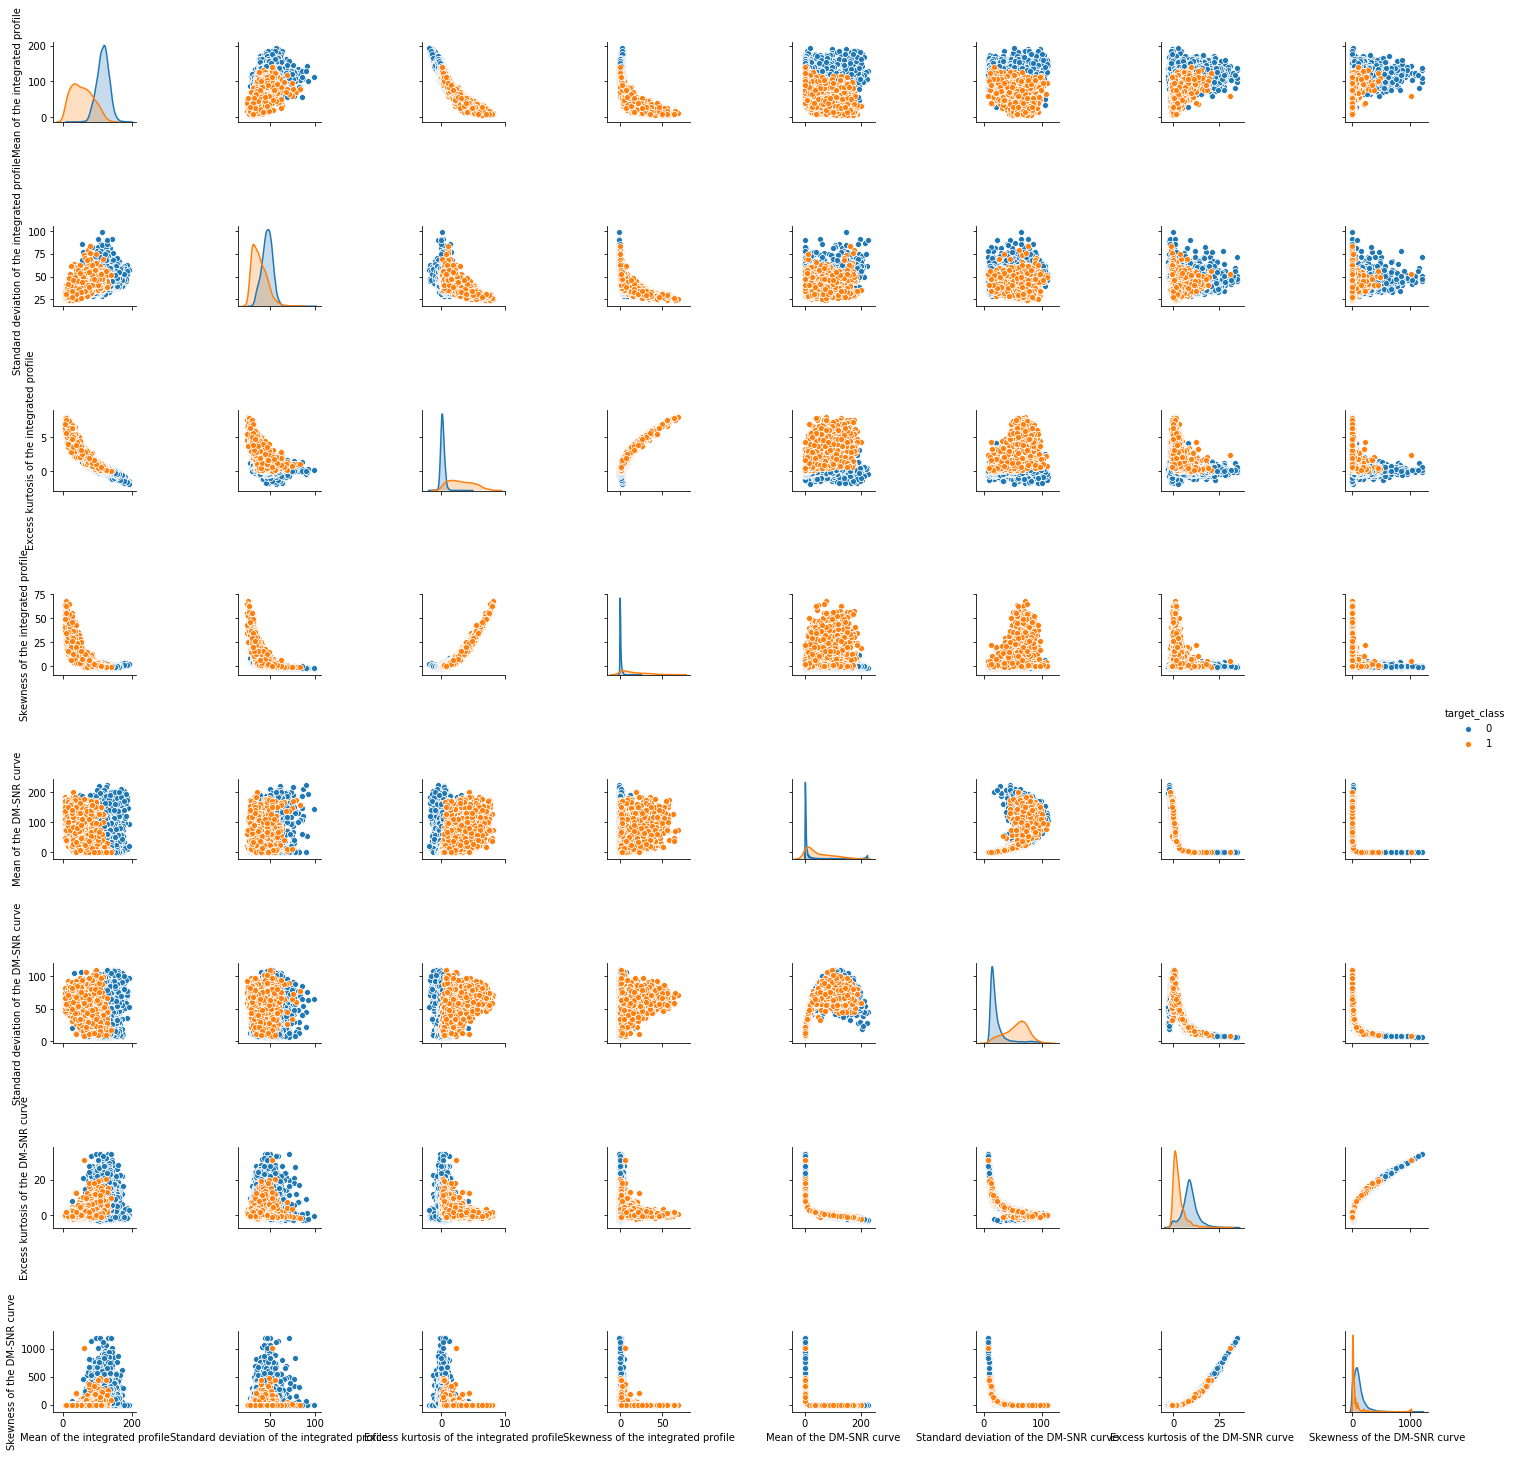

In [7]:
ax = sns.pairplot(df, vars=features, hue=target)
plt.show()

There doesn't seem to be any glaring outliers, however it looks like there may be some strong correlations between some of these features. I'll plot and display the correlation for each pair of features. 

,feature1,feature2,corr_coef,abs_corr_coef
0,Excess kurtosis of the integrated profile,Skewness of the integrated profile,0.945729,0.945729
1,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,0.923743,0.923743
2,Mean of the integrated profile,Excess kurtosis of the integrated profile,-0.873898,0.873898
3,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,-0.809786,0.809786
4,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,0.796555,0.796555
5,Mean of the integrated profile,Skewness of the integrated profile,-0.738775,0.738775
6,Mean of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,-0.615971,0.615971
7,Standard deviation of the DM-SNR curve,Skewness of the DM-SNR curve,-0.575800,0.575800
8,Mean of the integrated profile,Standard deviation of the integrated profile,0.547137,0.547137
9,Standard deviation of the integrated profile,Skewness of the integrated profile,-0.539793,0.539793


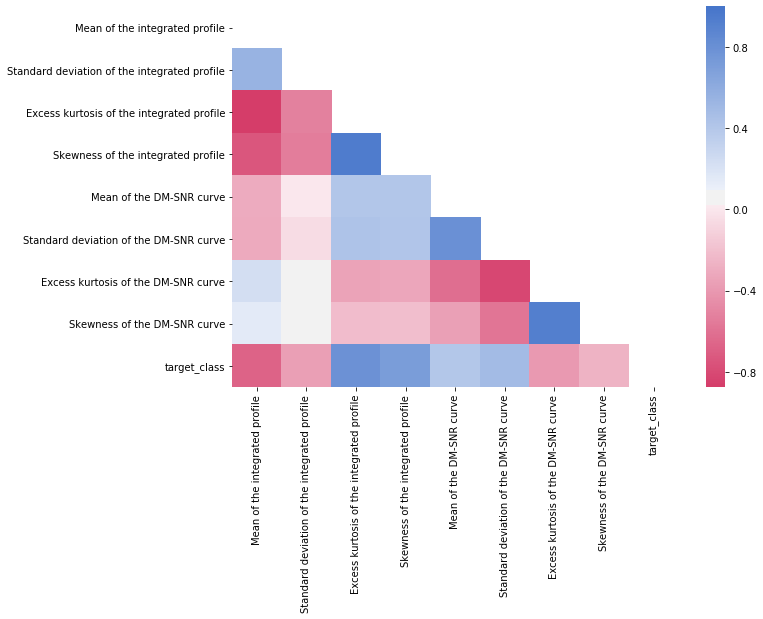

In [8]:
correlation_plot(df)
pairwise_corr(df, target)

There seems to be a decent amount of correlation between the features. This makes sense as many of these features are calculating different statistics based on the same curve/profile. 
<br><br>
In order to combat the multicollinearity, several techniques can be used. I will use L1 Regularization on a Logistic Regression model, although other techniques such as feature reduction before fitting a model are just as valid. L1 Regularization forces several coefficients to 0 and shrinks other coefficients, reducing the complexity of the model and the multicollinearity.

## Predicting a Pulsar Star

##### Feature Selection via Lasso

First, split the data and scale the standardize (center, scale) the features. Linear models are less interpretable when the features are on different scales; i.e., comparing coefficients of features on the same scale helps us interpret the results. Standardizing helps fit the data to a normal distribution (centering to 0, stdev of 1). 

In [9]:
X = np.array(df[features])
y = np.array(df[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=12)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std =  scaler.transform(X_test)

Now, we can test several strengths of regulariation on the L1 LogReg model. We vary the C hyperparamter and observe the effect on both the F1 score and the number of features retained.
<br><br>
C is the inverse of the regularization. As C approaches 1.0, the model collapses to the non-regularized Logistic Regression. Therefore, a lower value of C will give us a higher penalty and less features.   
<br>
Here, I tuned the value of C until I was given range of features between 0 and 7.

In [10]:
Cs = np.linspace(1e-10, 2e-2)
n_features=[]
scores=[]
for C in Cs:
    clf = LogisticRegression(penalty='l1', C=C, fit_intercept=False, 
                               solver='liblinear', random_state=12)
    clf.fit(X_train_std, y_train)
    n_features.append(len(features) - np.sum(clf.coef_==0))
    score = np.mean(cross_validate(clf,X_train_std, y_train, scoring='f1')['test_score'])
    scores.append(score) 

Let's plot both the F1 Score and the No. of Features as a result of the C hyperparameter of each model. The F1 Score is used as it is a better measure of binary classification as opposed to accuracy, which is susceptible to class imbalance (as is our case) and overfitting. (https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)

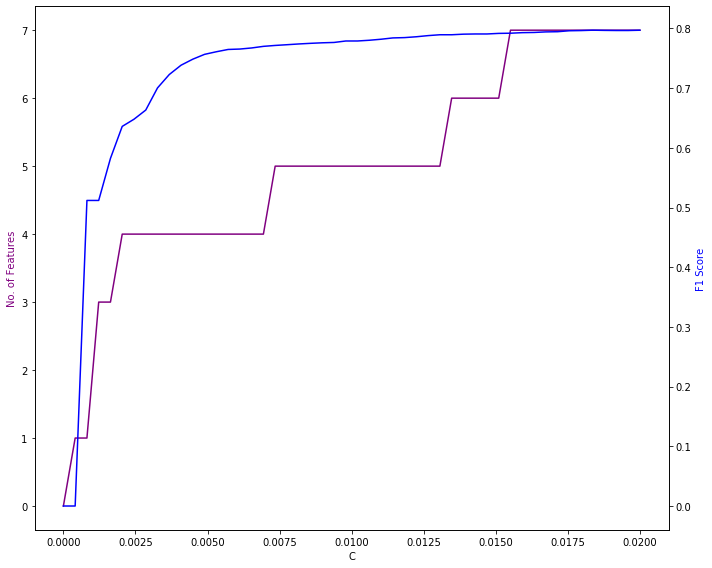

In [11]:
fig, ax1 = plt.subplots(figsize=(10,8))

ax1.set_xlabel('C')
ax2 = ax1.twinx()

ax1.plot(Cs, n_features, color='purple')
ax1.set_ylabel('No. of Features', color='purple')

ax2.plot(Cs, scores, color='blue')
ax2.set_ylabel('F1 Score', color='blue')

fig.tight_layout()
plt.show()

Here we see there is a trade-off of model performance and complexity; as C increases, the F1 Score increases, and the number of features jumps at certain values as well. We want to reduce the number of features but retain as much performance as possible. Let's take a look at the values of interest, i.e., the highest F1 Scores at each No. of Features. 

In [12]:
for i in range(len(n_features)-1):
    if n_features[i] != n_features[i+1]:
        print(n_features[i], np.round(scores[i],3), Cs[i])
print(n_features[-1], np.round(scores[-1],3), Cs[-1])

0 0.0 1e-10
1 0.512 0.0008163266265306123
3 0.582 0.0016326531530612245
4 0.77 0.006938775575510203
5 0.789 0.013061224524489795
6 0.792 0.015102040840816325
7 0.797 0.02


It looks like the F1 Score starts to bow around 4-5 features (via the plot), and there there is minimal gain between 5 and 7 features (0.79 vs .80) (via the printed outputs). I will use the C parameter that results in the highest F1 Score at 5 features.

##### Build the Model

Using this C hyperparameter, I can build my LogReg model, and test it on the holdout set. 

In [13]:
for i in range(len(n_features)):
    if n_features[i] == 5:
        C_final = Cs[i]
print("C for the final model = {}".format(np.round(C_final,3)))

C for the final model = 0.013


In [14]:
clf = LogisticRegression(penalty='l1', C=C_final, fit_intercept=False, 
                               solver='liblinear', random_state=12)
clf.fit(X_train_std, y_train)

LogisticRegression(C=0.013061224524489795, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
f1_final = clf.score(X_test_std, y_test)

print("F1 for our Regularized Model = {}".format(np.round(f1_final,3)))

F1 for our Regularized Model = 0.959


##### Feature Importance

Let's measure our feature importance. Unlike the notebook referenced below, I used a linear model. Therefore, I can calculate the feature importance based on the coefficients returned from the model.
<br><br>
https://www.kaggle.com/parulpandey/intrepreting-machine-learning-models/data#1.-Permutation-Importance-using-ELI5-library

In [16]:
model_features = [features[i] for i in range(len(features)) if clf.coef_[0][i]!=0]
model_features

['Mean of the integrated profile',
 'Standard deviation of the integrated profile',
 'Excess kurtosis of the integrated profile',
 'Skewness of the integrated profile',
 'Standard deviation of the DM-SNR curve']

In [17]:
feature_importance = np.round(abs(clf.coef_[0]) / abs(clf.coef_[0]).sum(), 4)

pd.DataFrame({'feature':features,
                'importance':feature_importance,
                'coef':clf.coef_[0]}).sort_values('importance', ascending=False)

,feature,importance,coef
3,Skewness of the integrated profile,0.7557,10.580729
2,Excess kurtosis of the integrated profile,0.1003,1.404366
1,Standard deviation of the integrated profile,0.0898,1.256711
0,Mean of the integrated profile,0.0491,0.688173
5,Standard deviation of the DM-SNR curve,0.0051,0.071894
4,Mean of the DM-SNR curve,0.0000,0.000000
6,Excess kurtosis of the DM-SNR curve,0.0000,0.000000
7,Skewness of the DM-SNR curve,0.0000,0.000000


It looks like more than **75% of determining whether the observation is a pulsar star or not comes from the skewness of the integreated profile**. Not surprisingly, the excess kurtosis of the integrated profile importance is also large, due to its high correlation with the skewness (as shown below). The features of the DM-SNR curve seem to offer little-to-no determination in whether it is a pulsar star or not.

In [18]:
pairwise_corr(df[model_features])

,feature1,feature2,corr_coef,abs_corr_coef
0,Excess kurtosis of the integrated profile,Skewness of the integrated profile,0.945729,0.945729
1,Mean of the integrated profile,Excess kurtosis of the integrated profile,-0.873898,0.873898
2,Mean of the integrated profile,Skewness of the integrated profile,-0.738775,0.738775
3,Mean of the integrated profile,Standard deviation of the integrated profile,0.547137,0.547137
4,Standard deviation of the integrated profile,Skewness of the integrated profile,-0.539793,0.539793
5,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,-0.521435,0.521435
6,Excess kurtosis of the integrated profile,Standard deviation of the DM-SNR curve,0.432880,0.432880
7,Skewness of the integrated profile,Standard deviation of the DM-SNR curve,0.415140,0.415140
8,Mean of the integrated profile,Standard deviation of the DM-SNR curve,-0.307016,0.307016
9,Standard deviation of the integrated profile,Standard deviation of the DM-SNR curve,-0.047632,0.047632


Let's take a look at the feature importance calculated via the Permutation Importance.

In [19]:
perm = PermutationImportance(clf, random_state=12).fit(X_test_std, y_test)
eli5.show_weights(perm, feature_names = df.drop(target, axis=1).columns.tolist())

Weight,Feature
0.1852 ± 0.0089,Skewness of the integrated profile
0.0572 ± 0.0055,Standard deviation of the integrated profile
0.0480 ± 0.0031,Excess kurtosis of the integrated profile
0.0112 ± 0.0014,Mean of the integrated profile
0.0004 ± 0.0005,Standard deviation of the DM-SNR curve
0 ± 0.0000,Skewness of the DM-SNR curve
0 ± 0.0000,Excess kurtosis of the DM-SNR curve
0 ± 0.0000,Mean of the DM-SNR curve


As expected, the results are about the same - the integreated profile features are most important, and are in approximately the same order as above. I'll use the LogReg coefficients going forward

## Direct Feature Reduction

While our results above are sufficient (>95% F1 Score), what we see from the feature importance is that several statistics on the same profile are providing almost all the determination of the target class. It seems the L1 Regularization, while decreasing model complexity, simply just dropped all features that described the DM-SNR curve. Let's see if direct feature reduction can have a better result.

##### Feature Selection via Direct Feature Reduction

The code below takes finds the highest correlated features, determines which one is least correlated to the target, and drops that feature. This logic is repeated until the number of features dropped is equal to `n_features_to_drop`. The pairwise correlations of the remaining features are then shown via the `pairwise_corr` function. I'll drop 3 features to keep consistency with the above model.

In [20]:
n_features_to_drop = 3

to_drop = feature_reduction(n_features_to_drop, df, target)
to_keep = [col for col in df.columns if col not in to_drop]

pairwise_corr(df[to_keep], target)

,feature1,feature2,corr_coef,abs_corr_coef
0,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,-0.809786,0.809786
1,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,0.796555,0.796555
2,Mean of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,-0.615971,0.615971
3,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,-0.521435,0.521435
4,Excess kurtosis of the integrated profile,Standard deviation of the DM-SNR curve,0.432880,0.432880
5,Excess kurtosis of the integrated profile,Mean of the DM-SNR curve,0.414368,0.414368
6,Excess kurtosis of the integrated profile,Excess kurtosis of the DM-SNR curve,-0.341209,0.341209
7,Standard deviation of the integrated profile,Standard deviation of the DM-SNR curve,-0.047632,0.047632
8,Standard deviation of the integrated profile,Excess kurtosis of the DM-SNR curve,0.029429,0.029429
9,Standard deviation of the integrated profile,Mean of the DM-SNR curve,0.006869,0.006869


##### Build the Model

Let's repeat the model fitting from above with our new set of features. Here, we use standard LogReg since we already penalized/selected our features. 

In [21]:
X = np.array(df[to_keep].drop('target_class',axis=1))
y = np.array(df[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=12)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std =  scaler.transform(X_test)

In [22]:
clf_reduced = LogisticRegression(penalty='none', fit_intercept=False, random_state=12, solver='newton-cg')
clf_reduced.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=12, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
f1 = f1_score(y_test, clf_reduced.predict(X_test_std))

print("F1 for our Directe Feature Reduction Model = {}".format(np.round(f1,3)))

F1 for our Directe Feature Reduction Model = 0.558


While the number of features kept (5) was the same, using the direct feature reduction method decreased the F1 Score significantly.

##### Feature Importance 

In [28]:
feature_importance = np.round(abs(clf_reduced.coef_[0]) / abs(clf_reduced.coef_[0]).sum(), 4)

feat_imp_df = pd.DataFrame({'feature':df[to_keep].drop('target_class',axis=1).columns,
                            'importance':feature_importance,
                            'coef':clf_reduced.coef_[0]}).sort_values('importance', ascending=False)

for feature in to_drop:
    feat_imp_df = feat_imp_df.append({'feature':feature, 'importance':0, 'coef':0},ignore_index=True)

feat_imp_df

,feature,importance,coef
0,Excess kurtosis of the integrated profile,0.8595,6.168300
1,Standard deviation of the integrated profile,0.0723,0.518894
2,Standard deviation of the DM-SNR curve,0.0622,0.446591
3,Excess kurtosis of the DM-SNR curve,0.0055,-0.039290
4,Mean of the DM-SNR curve,0.0005,-0.003805
5,Skewness of the integrated profile,0.0000,0.000000
6,Skewness of the DM-SNR curve,0.0000,0.000000
7,Mean of the integrated profile,0.0000,0.000000


It looks like again, the integrated profile features provided the most information in determining the target class. We can see that a mixture of both the integrated profile and the DM-SNR curve features were dropped, however. 

In [25]:
pairwise_corr(df[to_keep], target)

,feature1,feature2,corr_coef,abs_corr_coef
0,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,-0.809786,0.809786
1,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,0.796555,0.796555
2,Mean of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,-0.615971,0.615971
3,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,-0.521435,0.521435
4,Excess kurtosis of the integrated profile,Standard deviation of the DM-SNR curve,0.432880,0.432880
5,Excess kurtosis of the integrated profile,Mean of the DM-SNR curve,0.414368,0.414368
6,Excess kurtosis of the integrated profile,Excess kurtosis of the DM-SNR curve,-0.341209,0.341209
7,Standard deviation of the integrated profile,Standard deviation of the DM-SNR curve,-0.047632,0.047632
8,Standard deviation of the integrated profile,Excess kurtosis of the DM-SNR curve,0.029429,0.029429
9,Standard deviation of the integrated profile,Mean of the DM-SNR curve,0.006869,0.006869


For this model, the two most important features are now only somewhat (-0.52 coef)  correlated. We have reduced the correlation of the top features but the performance of the model has suffered. 

## Conclusion

Two separate feature selection techniques were performed to reduce the multicollinearity of the features from this data set. 
* L1 Regularization of Logistic Regression resulted in top features derived from the *integrated profile*. This model showed a promising F1 score (>0.95)
* Direct Feature Reduction was also used, and resulted in elimination of features from both the integrated profile and the DM-SNR curve. This model's performance was far worse than the first (0.558)

Based on these observations, it can be concluded that higher performing models tend to weigh the *integrated profile* features higher. **Thus, it can be concluded that the integrated profile is more informative than the DM-SNR curve in determining whether an observation is a pulsar star or not.** 
<br><br>
Since these features are somewhat redundant and highly correlated, it is recommended that the data collection process be revisited to determine if additional features can be captured. Ideally, other profiles and curves can be measured outside of the integrated profile or the DM-SNR curve, which make up all the features of this data set.